### Misclassified Image SSIM Analysis

This notebook analyzes misclassified images and compares image similarities using SSIM to determine whether CIFAR10.1 misclassified images are less si than misclassified images in CIFAR10 test set. 


##### Import Libraries and Modules

In [ ]:
!pip install upsetplot

In [3]:
from skimage.measure import compare_ssim as ssim
from ast import literal_eval
import os
import pandas as pd
from glob import glob
import numpy as np
from sklearn.metrics import classification_report
import torchvision
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid
import seaborn as sns
import matplotlib.pyplot as plt
from upsetplot import plot 
from matplotlib import pyplot
%matplotlib inline

In [13]:
#collect data and labels for cifar 10 and 10.1

testset = torchvision.datasets.CIFAR10(root='../../data/cifar10/', train=False, download=True)
test_labels_CIFAR10 = testset.targets
test_data_CIFAR10 = testset.data

test_labels_CIFAR101 =np.load('/home/ec2-user/SageMaker/w210-capstone/data/cifar101/cifar10.1_v6_labels.npy')  
test_data_CIFAR101 = np.load('/home/ec2-user/SageMaker/w210-capstone/data/cifar101/cifar10.1_v6_data.npy')

# Create a dictionary that maps numeric class number to class name
class_dict = {0: "airplane",
              1: "automobile",
              2: "bird",
              3: "cat",
              4: "deer",
              5: "dog",
              6: "frog",
              7: "horse",
              8: "ship",
              9: "truck"}

classes = ['0 airplane', '1 automobile', '2 bird', '3 cat', '4  deer', '5 dog', '6 frog', 
           '7 horse', '8 ship', '9 truck']

# Confirm that when we compare these labels to our guesses, we get the accuracy score.
def confirm_score(zfile, test_labels):
    print("\nAccuracy:", zfile['acc'])
    print(" -> Sanity Check:", np.sum(test_labels_CIFAR10 == zfile['labels']), "of", 
          len(test_labels), "correct\n")
    
    # Examine the classes to see if the model is balanced in its accuracy across all labels 
    report = classification_report(test_labels, zfile['labels'], target_names=classes, output_dict=True)
    print(pd.DataFrame(report).transpose())


Files already downloaded and verified


In [11]:
number_to_analyze = 20

def error_by_r_score(zfile, test_labels, testset):
    images_to_print = []
    
    # Determine the probability we associatd with our predicted label
    pp_max = np.max(zfile['probs'], axis=1)

    # Retrieve the model's predicted probability of the correct label
    pp_correct = zfile['probs'][range(zfile['probs'].shape[0]), test_labels]

    # Calculate the R ratio for each document
    r = pp_max/pp_correct

    # Retrieve the row numbers where the R score is the highest
    max_r_value_indexes = r.argsort()[-1 * number_to_analyze:]

    # Create list to hold stats on highest R Score images
    stats = []
    
    for mi in max_r_value_indexes:
        #print("-- R Ratio:", r[mi], " ( index", mi, 
        #      ")\n   Guessed Label:", zfile['labels'][mi], class_dict[zfile['labels'][mi]], 
        #      "\n   Correct Label:", test_labels[mi], class_dict[test_labels[mi]],
        #      "\n   Class Probs:", zfile['probs'][mi], "\n")
        
        img_dict = {'prob_predicted': pp_max[mi],
                    'prob_correct': pp_correct[mi],
                    'r_value': r[mi],
                    'label_predicted_id': zfile['labels'][mi],
                    'label_predicted': class_dict[zfile['labels'][mi]],
                    'correct_label': test_labels[mi],
                    'correct_label_id': class_dict[test_labels[mi]],
                    'img_index': mi
                   }

        img=Image.fromarray(testset[mi])
        images_to_print.append(img)
        stats.append(img_dict)
        


    # Print the misclassified images
    fig = plt.figure(figsize=(16, 4))
    grid = ImageGrid(fig, 111,  
                     nrows_ncols=(2, 10),  
                     axes_pad=0.1,  
                     )

    for ax, im in zip(grid, images_to_print):
        # Iterating over the grid returns the Axes.
        ax.imshow(im)
        
    return pd.DataFrame(stats)

In [ ]:
file_path = '/home/ec2-user/SageMaker/w210-capstone/original_model_results/'
models = ['resnet_basic_32', 'resnet_basic_32_ra_2_5', 'resnet_basic_32_ra_2_20', 'resnet_basic_32_ra_3_20'
          'resnext_29_4x64d', 'resnext_29_4x64d_ra_2_5', 'resnext_29_4x64d_ra_2_20', 'resnext_29_4x64d_ra_3_20', 
          'wrn_28_10', 'wrn_28_10_ra_2_5', 'wrn_28_10_ra_2_20', 'wrn_28_10_ra_3_20', 
          'densenet_BC_100_12', 'densenet_BC_100_12_ra_2_5', 'densenet_BC_100_12_ra_2_20', 'densenet_BC_100_12_ra_3_20']
filename = '/predictions_400'
output = file_path + model + filename + '.npz'

npzfile = np.load(output)
df_resnet32_errors = error_by_r_score(npzfile, test_labels_CIFAR10, test_data_CIFAR10)

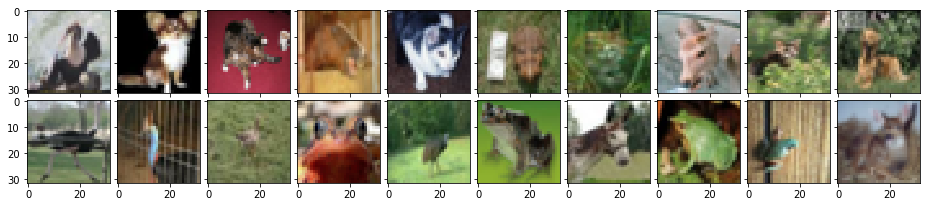

In [80]:
output = '/home/ec2-user/SageMaker/w210-capstone/original_model_results/resnet_basic_32_ra_2_5/predictions_400.npz'
npzfile = np.load(output)
resnet_basic_32_ra_2_5_pred_400 = error_by_r_score(npzfile, test_labels_CIFAR10, test_data_CIFAR10)

In [72]:
output = '/home/ec2-user/SageMaker/w210-capstone/original_model_results/resnet_basic_32/predictions_160.npz'
npzfile = np.load(output)
confirm_score(npzfile, test_labels_CIFAR10)


Accuracy: 0.9232
 -> Sanity Check: 9232 of 10000 correct

              f1-score  precision  recall  support
0 airplane    0.930439   0.918208  0.9430   1000.0
1 automobile  0.965483   0.965966  0.9650   1000.0
2 bird        0.898449   0.898899  0.8980   1000.0
3 cat         0.841150   0.848423  0.8340   1000.0
4  deer       0.922007   0.916091  0.9280   1000.0
5 dog         0.876574   0.883249  0.8700   1000.0
6 frog        0.947791   0.951613  0.9440   1000.0
7 horse       0.947421   0.948847  0.9460   1000.0
8 ship        0.953523   0.953047  0.9540   1000.0
9 truck       0.948104   0.946215  0.9500   1000.0
micro avg     0.923200   0.923200  0.9232  10000.0
macro avg     0.923094   0.923056  0.9232  10000.0
weighted avg  0.923094   0.923056  0.9232  10000.0


In [16]:
output = '/home/ec2-user/SageMaker/w210-capstone/original_model_results/resnet_basic_32/predictions_160_CIFAR101.npz'
npzfile101 = np.load(output)
confirm_score(npzfile101, test_labels_CIFAR101)


Accuracy: 0.832
 -> Sanity Check: 0 of 2000 correct

              f1-score  precision  recall  support
0 airplane    0.772846   0.808743   0.740    200.0
1 automobile  0.837466   0.932515   0.760    200.0
2 bird        0.824096   0.795349   0.855    200.0
3 cat         0.700508   0.711340   0.690    200.0
4  deer       0.873449   0.866995   0.880    200.0
5 dog         0.812030   0.814070   0.810    200.0
6 frog        0.882793   0.880597   0.885    200.0
7 horse       0.895000   0.895000   0.895    200.0
8 ship        0.859903   0.831776   0.890    200.0
9 truck       0.855140   0.802632   0.915    200.0
micro avg     0.832000   0.832000   0.832   2000.0
macro avg     0.831323   0.833902   0.832   2000.0
weighted avg  0.831323   0.833902   0.832   2000.0


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:28: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


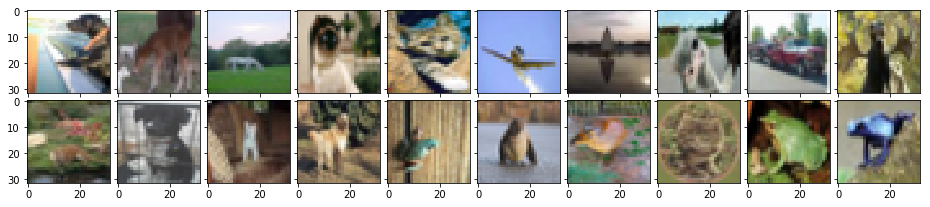

In [17]:
df_resnet32_errors = error_by_r_score(npzfile, test_labels_CIFAR10, test_data_CIFAR10)

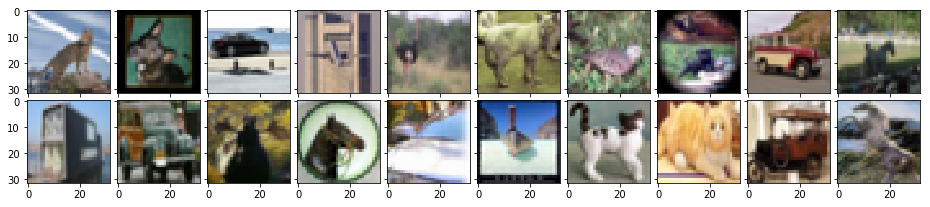

In [65]:
df_resnet32_errors_101  = error_by_r_score(npzfile101, test_labels_CIFAR101, test_data_CIFAR101)

In [64]:

def mse(image1, image2):
    error = np.sum((image1.astype("float") - image2.astype("float")) ** 2)
    error /= float(image1.shape[0] * image1.shape[1])
    return error

def compare_images(image1, image2):
    # mean square error between each pixel for the two images, higher the MSE mean less similar
    m = mse(image1, image2)
    # similarities within pixels, score of one is very similar and lower means less similar
    s = ssim(image1, image2, multichannel=True)
    return m, s



/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/skimage/util/arraycrop.py:177: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = ar[slices]


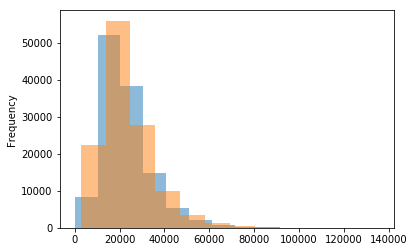

In [76]:
# resnet32 on CIFAR10 without augmentation
for im in df_resnet32_errors['img_index']:
    for i in range(0,2000):
        mse_ssim_cifar10 = compare_images(test_data_CIFAR10[i], test_data_CIFAR10[im])
        #print("CIFAR10:   MSE:  %.2f SSIM: %.3f" % mse_ssim_cifar10)
        mse_ssim_cifar101 = compare_images(test_data_CIFAR101[i], test_data_CIFAR10[im]) 
        #print("CIFAR10.1: MSE:  %.2f SSIM: %.3f" % mse_ssim)
        #print('\n')

        stats_dict = {'CIFAR10_MSE': mse_ssim_cifar10[0], 'CIFAR10_SSIM': mse_ssim_cifar10[1],
                      'CIFAR101_MSE': mse_ssim_cifar101[0], 'CIFAR101_SSIM': mse_ssim_cifar101[1]}
        comparison_stats.append(stats_dict)

df_comparison_stats = pd.DataFrame(comparison_stats)

plt1 = df_comparison_stats['CIFAR10_MSE'].plot.hist(bins=12, alpha=0.5)
plt2 = df_comparison_stats['CIFAR101_MSE'].plot.hist(bins=12, alpha=0.5)


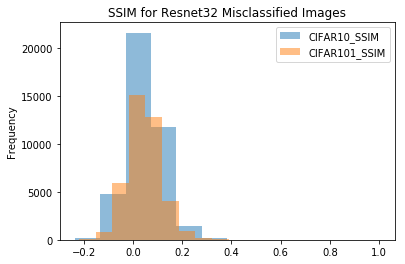

In [108]:
plt1 = df_comparison_stats['CIFAR10_SSIM'].plot.hist(bins=12, alpha=0.5, title='SSIM for Resnet32 Misclassified Images', legend=1)
plt2 = df_comparison_stats['CIFAR101_SSIM'].plot.hist(bins=12, alpha=0.5, title='SSIM for Resnet32 Misclassified Images', legend=1)

In [78]:
print(np.mean(df_comparison_stats['CIFAR10_MSE']))
print(np.mean(df_comparison_stats['CIFAR101_MSE']))
print(np.mean(df_comparison_stats['CIFAR10_SSIM']))
print(np.mean(df_comparison_stats['CIFAR101_SSIM']))

22855.03258076652
23498.696773013256
0.043346891266384024
0.041021843896659


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/skimage/util/arraycrop.py:177: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = ar[slices]


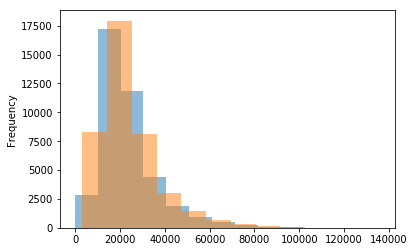

In [97]:
# resnet32 on CIFAR10.1 without augmentation
for im in df_resnet32_errors_101['img_index']:
    for i in range(0,2000):
        mse_ssim_cifar10 = compare_images(test_data_CIFAR10[i], test_data_CIFAR10[im])
        mse_ssim_cifar101 = compare_images(test_data_CIFAR101[i], test_data_CIFAR10[im]) 

        stats_dict = {'CIFAR10_MSE': mse_ssim_cifar10[0], 'CIFAR10_SSIM': mse_ssim_cifar10[1],
                      'CIFAR101_MSE': mse_ssim_cifar101[0], 'CIFAR101_SSIM': mse_ssim_cifar101[1]}
        comparison_stats.append(stats_dict)

df_comparison_stats = pd.DataFrame(comparison_stats)

plt1 = df_comparison_stats['CIFAR10_MSE'].plot.hist(bins=12, alpha=0.5)
plt2 = df_comparison_stats['CIFAR101_MSE'].plot.hist(bins=12, alpha=0.5)

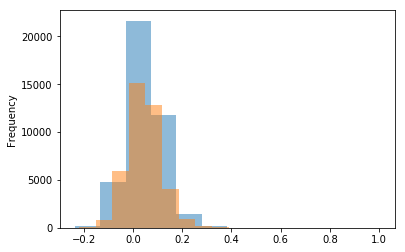

In [98]:
plt1 = df_comparison_stats['CIFAR10_SSIM'].plot.hist(bins=12, alpha=0.5)
plt2 = df_comparison_stats['CIFAR101_SSIM'].plot.hist(bins=12, alpha=0.5)

In [99]:
print(np.mean(df_comparison_stats['CIFAR10_MSE']))
print(np.mean(df_comparison_stats['CIFAR101_MSE']))
print(np.mean(df_comparison_stats['CIFAR10_SSIM']))
print(np.mean(df_comparison_stats['CIFAR101_SSIM']))

23502.267153195076
24195.5622465947
0.0493459706655803
0.04635673755491243


In [103]:
# calculate SSIM and MSE for various models

def calc_SSIM_MSE(model_error_df, testing_cifar_version):
    comparison_stats = []
    for im in model_error_df['img_index']:
        for i in range(0,2000):
            mse_ssim_cifar10 = compare_images(test_data_CIFAR10[i], test_data_CIFAR10[im])
            mse_ssim_cifar101 = compare_images(test_data_CIFAR101[i], test_data_CIFAR10[im]) 

            stats_dict = {'CIFAR10_MSE': mse_ssim_cifar10[0], 'CIFAR10_SSIM': mse_ssim_cifar10[1],
                          'CIFAR101_MSE': mse_ssim_cifar101[0], 'CIFAR101_SSIM': mse_ssim_cifar101[1]}
            comparison_stats.append(stats_dict)
    return pd.DataFrame(comparison_stats)


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/skimage/util/arraycrop.py:177: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = ar[slices]


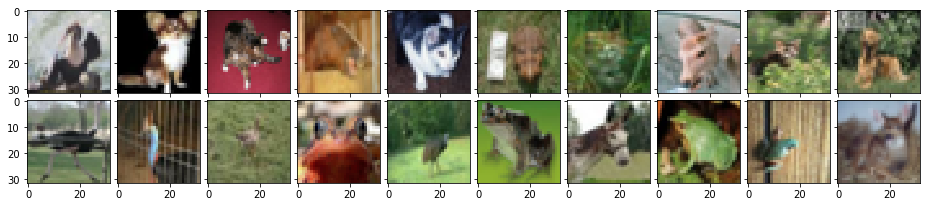

In [104]:
output = '/home/ec2-user/SageMaker/w210-capstone/original_model_results/resnet_basic_32_ra_2_5/predictions_400.npz'
npzfile = np.load(output)
resnet_basic_32_ra_2_5_pred_400 = error_by_r_score(npzfile, test_labels_CIFAR10, test_data_CIFAR10)
met_resnet_basic_32_ra_2_5_pred_400 = calc_SSIM_MSE(resnet_basic_32_ra_2_5_pred_400, 'CIFAR10')

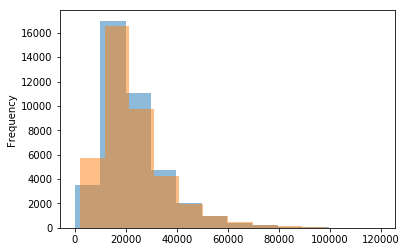

In [105]:
plt1 = met_resnet_basic_32_ra_2_5_pred_400['CIFAR10_MSE'].plot.hist(bins=12, alpha=0.5)
plt2 = met_resnet_basic_32_ra_2_5_pred_400['CIFAR101_MSE'].plot.hist(bins=12, alpha=0.5)

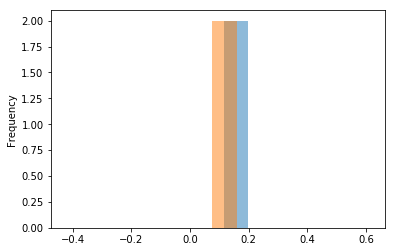

In [96]:
plt1 = met_resnet_basic_32_ra_2_5_pred_400['CIFAR10_SSIM'].plot.hist(bins=12, alpha=0.5)
plt2 = met_resnet_basic_32_ra_2_5_pred_400['CIFAR101_SSIM'].plot.hist(bins=12, alpha=0.5)

In [75]:
print(np.mean(df_comparison_stats['CIFAR10_MSE']))
print(np.mean(df_comparison_stats['CIFAR101_MSE']))
print(np.mean(df_comparison_stats['CIFAR10_SSIM']))
print(np.mean(df_comparison_stats['CIFAR101_SSIM']))

23089.679737781058
23750.369393804784
0.04470155982023521
0.04220246274933421
